In [283]:
import os
import numpy as np
import pandas as pd
from collections import deque

!pip install music21
!pip install pygame

# Create the user environment for music21
import music21
us = music21.environment.UserSettings()
us['musicxmlPath'] = 'C:/Program Files/MuseScore 3/bin/MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 3/bin/MuseScore3.exe'
from music21 import converter, instrument, note, chord, bar, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [284]:
# grab / parse data

In [234]:
midi_directory = "midi/Piano"
# specify the number of track in each song (should be the same, in same order, for each song)
tracks = (0,)
instru = instrument.Piano()

notes = [[] for track in tracks]
durations = [[] for track in tracks]
for i, file in enumerate(os.listdir(midi_directory)):
    midi_part = converter.parse(os.path.join(midi_directory, file))
    # Parse the midi file by the notes/chords it contains
    for track, _ in enumerate(tracks):
        notes_to_parse = midi_part[tracks[track]].flat.notesAndRests
        notes_to_parse = notes_to_parse.makeMeasures()
        for meas in notes_to_parse:
            for elem in meas:
                if isinstance(elem, note.Note):
                    notes[track].append([str(elem.pitch)])
                elif isinstance(elem, chord.Chord):
                    notes[track].append([str(n.nameWithOctave) for n in elem.pitches])
                elif isinstance(elem, note.Rest):
                    notes[track].append([elem.name])
                durations[track].append(elem.quarterLength)
        notes[track].append(["rest"])
        durations[track].append(4.0)
    print("Song %s Loaded" % file)
print("DONE LOADING SONGS") 
# Get all notes
np_notes = [np.array(notes[track]) for track in tracks]
np_notes = [np_notes[track].flatten() for track in tracks]
notes_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for item in np_notes[track]:
        if len(item) > 1 and item != "rest":
            notes_vocab[track].append(",".join([note for note in item]))
        else:
            notes_vocab[track].append(item[0])
    notes_vocab[track] = sorted(set(notes_vocab[track]))
# Get all durations
durations_vocab = [[] for track in tracks]
for track, _ in enumerate(tracks):
    durations_vocab[track] = sorted(set(durations[track]))

for track, _ in enumerate(tracks):
    print("%s Notes, notes_Vocab : %s ; durations_Vocab : %s" % (len(notes[track]), len(notes_vocab[track]), len(durations_vocab[track])))
print(notes_vocab, notes)
print(durations_vocab, durations)

Song Bach_2PartInv_No1_in_C_BWV772.mid Loaded
Song Bach_2PartInv_No8_in_F_BWV779.mid Loaded
Song Etude op10 n01.mid Loaded
Song Etude op10 n02.mid Loaded
Song Etude op10 n10.mid Loaded
Song firstmvm.mid Loaded
Song gigue.mid Loaded
Song gigue1.mid Loaded
Song jg_bps27.mid Loaded
Song jsb2pin1.mid Loaded
Song jsb2pin4.mid Loaded
Song jsb2pin8.mid Loaded
Song moonlite.mid Loaded
Song secondmv.mid Loaded
Song sonat-1.mid Loaded
Song sonat-2.mid Loaded
Song sonat-8.mid Loaded
Song sonat-9.mid Loaded
Song thirdmvm.mid Loaded
Song zbach850.mid Loaded
DONE LOADING SONGS
14914 Notes, notes_Vocab : 1252 ; durations_Vocab : 100
[['A1', 'A1,A2', 'A1,A2,F#4', 'A1,A5,E5', 'A1,E4', 'A2', 'A2,A1', 'A2,A1,C#6', 'A2,A1,C#6,A5,E5', 'A2,A3', 'A2,A4,E4,C4', 'A2,A5,E5,C#6', 'A2,C#5,F#5,A5,C#6,A1', 'A2,C4', 'A2,E-2', 'A2,E-5,A4,C5', 'A2,E-5,C5,A4', 'A2,F5,D5,A4', 'A3', 'A3,A2', 'A3,A2,C4', 'A3,A4', 'A3,C#4,E-4,A4,F#1,F#2', 'A3,C#4,E4,C#5', 'A3,C#4,F#4', 'A3,C4,E3,E4', 'A3,C4,E4,A5,E5', 'A3,C4,F4', 'A3,D4,F#

In [235]:
# turn notes to integers:

In [236]:
cat_notes = [[] for track in tracks]
cat_durations = [[] for track in tracks]
for track, _ in enumerate(tracks):
    for elem in notes[track]:
        int_note = notes_vocab[track].index(",".join(elem))
        cat = np.zeros((len(notes_vocab[track])))
        cat[int_note] = 1
        cat_notes[track].append(cat)
    for elem in durations[track]:
        int_duration = durations_vocab[track].index(elem)
        cat = np.zeros((len(durations_vocab[track])))
        cat[int_duration] = 1
        cat_durations[track].append(cat)
# merge
x = [cat_notes, cat_durations]

In [237]:
# Build generator

In [238]:
seq_len = 32
batch_size = 32
#split = int(0.8 * len(x))

class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
    def __len__(self):
        return len(self.x[0][0]) // self.batch_size - 1
    def __getitem__(self, idx):
        X_note = [[] for track in tracks]
        X_duration = [[] for track in tracks]
        Y_note = [[] for track in tracks]
        Y_duration = [[] for track in tracks]
        res = [[], []]
        for track, _ in enumerate(tracks):
            for i in range(self.batch_size):
                X_note[track].append(self.x[0][track][idx+i : idx+i + seq_len])
                X_duration[track].append(self.x[1][track][idx+i : idx+i + seq_len])
                Y_note[track].append(self.x[0][track][idx+i + seq_len])
                Y_duration[track].append(self.x[1][track][idx+i + seq_len])
            X_note[track] = np.array(X_note[track])
            X_duration[track] = np.array(X_duration[track])
            Y_note[track] = np.array(Y_note[track])
            Y_duration[track] = np.array(Y_duration[track])
            res[0].append(X_note[track])
            res[0].append(X_duration[track])
            res[1].append(Y_note[track])
            res[1].append(Y_duration[track])
        return res
data_gen = dataGenerator(x, batch_size)

In [239]:
# Build Model

In [259]:
K.clear_session()

inputs_list = []
tracks_list = []
outputs_list = []

for track, _ in enumerate(tracks):
    in_note = Input(shape=(seq_len, len(notes_vocab[track])))
    inputs_list.append(in_note)
    x1 = Bidirectional(LSTM(32))(in_note)
    tracks_list.append(x1)
    in_duration = Input(shape=(seq_len, len(durations_vocab[track])))
    inputs_list.append(in_duration)
    x2 = Bidirectional(LSTM(32))(in_duration)
    tracks_list.append(x2)

concat = Concatenate()(tracks_list)
shared = Dense(64, activation='relu')(concat)

for track, _ in enumerate(tracks):
    out_note = Dense(len(notes_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_note)
    out_duration = Dense(len(durations_vocab[track]), activation='softmax')(shared)
    outputs_list.append(out_duration)

model = Model(inputs=inputs_list, 
              outputs=outputs_list)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 1252)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 100)      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64)           328960      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 64)           34048       input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

In [260]:
#save best model if model improved
model_name = "Piano_Mozart_Chopin_Batch_Beethoven.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [275]:
h = model.fit_generator(data_gen, epochs = 5, callbacks=[best_checkpoint])

Epoch 1/5
465/465 [==============================] - 164s 352ms/step - loss: 0.1370 - dense_2_loss: 0.1186 - dense_3_loss: 0.0185 - dense_2_acc: 0.9745 - dense_3_acc: 0.9951
Epoch 2/5
465/465 [==============================] - 198s 426ms/step - loss: 0.0276 - dense_2_loss: 0.0252 - dense_3_loss: 0.0024 - dense_2_acc: 0.9995 - dense_3_acc: 1.0000
Epoch 3/5
465/465 [==============================] - 192s 413ms/step - loss: 0.1214 - dense_2_loss: 0.1097 - dense_3_loss: 0.0117 - dense_2_acc: 0.9739 - dense_3_acc: 0.9968
Epoch 4/5
465/465 [==============================] - 193s 414ms/step - loss: 0.0176 - dense_2_loss: 0.0159 - dense_3_loss: 0.0018 - dense_2_acc: 0.9995 - dense_3_acc: 1.0000
Epoch 5/5
465/465 [==============================] - 182s 390ms/step - loss: 0.0110 - dense_2_loss: 0.0099 - dense_3_loss: 0.0011 - dense_2_acc: 0.9998 - dense_3_acc: 1.0000


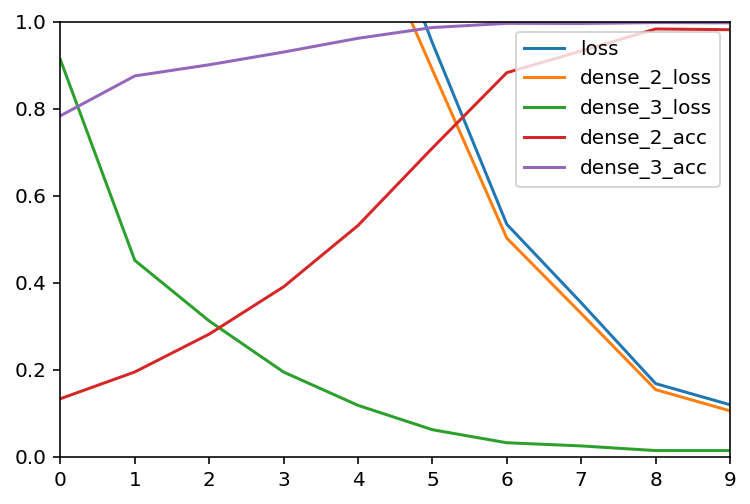

In [262]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [263]:
# Load / save

In [276]:
model_name = "Piano_Mozart_Chopin_Batch_Beethoven.h5"
model.save(model_name)
#model = load_model(model_name)

In [277]:
# Test

In [278]:
# Build seed
idx = 42
x_test, _ = data_gen[idx]
x_test = [x_test[i][0] for i in range(len(x_test))]
x_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(seq_len):
        str_note = notes_vocab[track][np.argmax(x_test[2*track][i])]
        duration = durations_vocab[track][np.argmax(x_test[2*track+1][i])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = duration
            x_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = duration
                x_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = duration
                x_test_stream[track].append(_rest)
    x_test_stream[track].insert(0, instru)

In [279]:
# make seq_len predictions from seed
preds = [[] for track in tracks]
x = x_test

for _ in range(seq_len*2):
    pred = model.predict([np.array([x[i]]) for i in range(len(x))])
    _note = [pred[i] for i in range(0, len(pred), 2)]
    _duration = [pred[i] for i in range(1, len(pred), 2)]
    for track, _ in enumerate(tracks):
        cat_note = np.zeros((len(notes_vocab[track])))
        _note[track] = np.argmax(_note[track])
        cat_note[_note[track]] = 1
        cat_duration = np.zeros((len(durations_vocab[track])))
        _duration[track] = np.argmax(_duration[track])
        cat_duration[_duration[track]] = 1
        x[2*track] = x[2*track][1:]
        x[2*track] = list(x[2*track]) + [cat_note]
        x[2*track+1] = x[2*track+1][1:]
        x[2*track+1] = list(x[2*track+1]) + [cat_duration]
        preds[track].append((cat_note, cat_duration))

In [280]:
# Build predicted stream
y_test_stream = [stream.Stream() for track in tracks]

for track, _ in enumerate(tracks):
    for i in range(len(preds[track])):
        str_note = notes_vocab[track][np.argmax(preds[track][i][0])]
        duration = durations_vocab[track][np.argmax(preds[track][i][1])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = duration
            y_test_stream[track].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = duration
                y_test_stream[track].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = duration
                y_test_stream[track].append(_rest)
    y_test_stream[track].insert(0, instru)

In [281]:
# play seed
x_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(x_test_stream[track])
    x_full_score.insert(0, p)
x_full_score.makeMeasures()#.show('musicxml')
x_full_score.chordify()
x_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_full_score)
sp.play()

In [282]:
# play generated music
y_full_score = stream.Score()
for track, _ in enumerate(tracks):
    p = stream.Part()
    p.append(y_test_stream[track])
    y_full_score.insert(0, p)
y_full_score.makeMeasures()#.show('musicxml')
y_full_score.chordify()
y_full_score.write("midi", "y_test.mid")
sp = midi.realtime.StreamPlayer(y_full_score)
sp.play()